In [34]:
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
import numpy as np
%config InlineBackend.figure_format = "svg"

In [2]:
# 加载数据及标签
X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False
)
y = list(map(int, y))

In [104]:
# Split data into train partition and test partition
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

In [105]:
X_train = X_train[0:800,:]
X_test = X_test[800:1000,:]
y_train = y_train[0:800]
y_test = y_test[800:1000]

In [7]:
def show(X):
    some_digit = X
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
    plt.axis("off")
    plt.show()

In [135]:
class MLP:
    """
    多层感知机
    """
    def __init__(
            self, 
            in_feature=784,
            hidden_neurons=150,
            out_feature=10,
            learning_rate = 0.01,
            max_iter=200,
            output_process=None
        ):
        """
        初始化神经网络的基本参数
        
        Parameters
        ----------
        in_feature: int
        输入向量维度
        
        hidden_neurons: int
        隐层神经元个数
        
        out_feature: int
        输出层神经元个数，与分类类别的个数保持一致
        
        learning_rate: float
        学习率
        
        max_iter: int
        最大迭代次数
        
        output_process: int or None
        输出训练过程
        None: 不输出训练过程
        int: 每迭代output_process个epoch, 输出epoch, train_loss, train_err(%)
        """
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        
        self.w_hidden = np.random.normal(loc=0, scale=1, size=(hidden_neurons, in_feature)) # 隐层权重
        self.bias_hidden = np.random.normal(loc=1, scale=1, size=(hidden_neurons)) # 隐层偏置
        self.w_output = np.random.normal(loc=0, scale=1, size=(out_feature, hidden_neurons)) # 输出层权重
        self.bias_output = np.random.normal(loc=1, scale=1, size=(out_feature)) # 输出层偏置
        
        self.train_loss_list = []
        self.train_acc_list = []
        self.test_loss_list = []
        self.test_acc_list = []
        
        self.train = False
        self.output_process = output_process
        
    def _tanh_act_fn(self,induced_local_field):
        return np.tanh(induced_local_field)

    
    def _sigmoid_act_fn(self,induced_local_field):
        return 1 / (1 + np.exp(-1*induced_local_field))

    
    def _der_tanh(self,induced_local_field):
        return 1 - (np.tanh(induced_local_field)**2)

    
    def _der_sigmoid(self,induced_local_field):
        sigmoid_u = self._sigmoid_act_fn(induced_local_field)
        return sigmoid_u * (1 - sigmoid_u)
    
    def _fit_one_epoch(self,X,y_label, train_mean):
        train_acc = train_loss = 0
        train_size = X.shape[0]
        for i in range(train_size):
            x = (X[i].flatten() - train_mean) / 255
            # feedforward
            V = self.w_hidden @ x + self.bias_hidden
            y = self._tanh_act_fn(V)
            V_d = self.w_output @ y + self.bias_output
            y_d = self._sigmoid_act_fn(V_d)

            # one hot encoding
            actual_one_hot = np.zeros((self.out_feature, 1))
            desired_one_hot = np.zeros((self.out_feature, 1))
            actual_one_hot[np.argmax(y_d), :] = 1
            desired_one_hot[y_label[i], :] = 1

            # feedback
            e = (desired_one_hot - y_d.reshape((self.out_feature, 1))).reshape(self.out_feature)
            last_layer_bp = self._der_sigmoid(V_d) * e
            first_layer_bp = self._der_tanh(V) * (self.w_output.T @ last_layer_bp)

            # weight gradient
            delta_w_hidden = (-1 * x.reshape(self.in_feature, 1) @
                              first_layer_bp.reshape(self.hidden_neurons, 1).T).T
            delta_bias_hidden = -1 * first_layer_bp
            delta_w_output = (-1 * y.reshape(self.hidden_neurons, 1)
                              @ last_layer_bp.reshape(1, self.out_feature)).T
            delta_bias_output = -1 * last_layer_bp

            # weight update
            eta = self.learning_rate
            self.w_hidden = self.w_hidden - eta * delta_w_hidden
            self.bias_hidden = self.bias_hidden - eta * delta_bias_hidden
            self.w_output = self.w_output - eta * delta_w_output
            self.bias_output = self.bias_output - eta * delta_bias_output

            train_loss += np.linalg.norm(e)**2
            if np.argmax(y_d) == y_label[i]:
                train_acc += 1

        train_loss /= train_size

        return train_loss, train_acc
    
    def fit(self, X, y):
        """
        使用多层感知机拟合模型
        
        Parameters
        ----------
        X : ndarray matrix of shape (n_samples, n_features)
            The input data.
            
        y : ndarray of shape (n_samples,)
            The target values
        
        Returns
        -------
        self : object
            Returns a trained MLP model.
        """
        train_mean = np.mean(X[0:X.shape[0]].flatten())
        epoch = 1
        while epoch <= self.max_iter:
            train_loss, train_acc = self._fit_one_epoch(X,y, train_mean)
            train_loss = round(train_loss,3)
            train_acc  = round(train_acc/X.shape[0]*100,3)
            
            self.train_loss_list.append(train_loss)
            self.train_acc_list.append(train_acc)
            
            if self.output_process is not None and epoch % self.output_process == 0:
                print('epoch: {}, train_loss:{}, train_acc:{}%'.format(epoch, 
                                                                train_loss, 
                                                                train_acc))
            epoch += 1
        
        self.train = True
        return self
    
    def score(self, X, y_label):
        """
        使用多层感知机预测数据
        
        Parameters
        ----------
        X : ndarray matrix of shape (n_samples, n_features)
            The input data.
            
        y_label : ndarray of shape (n_samples,)
            The target values
        
        Returns
        -------
        float: between 0-1
            Returns predict accuracy on X.
        """
        test_size = X.shape[0]
        test_mean = np.mean(X[0:X.shape[0]].flatten())
        test_acc = 0
        for i in range(test_size):
            x = (X[i].flatten() - test_mean) / 255
            # feedforward
            V = self.w_hidden @ x + self.bias_hidden
            y = self._tanh_act_fn(V)
            V_d = self.w_output @ y + self.bias_output
            y_d = self._sigmoid_act_fn(V_d)

            if np.argmax(y_d) == y_label[i]:
                test_acc += 1

        return test_acc/test_size
        
    def show(self):
        """
        可视化训练过程
        
        Note
        ----------
        只有当模型进行了训练时才能调用该函数
        否则将引起报错
        """
        assert self.train == True, "The model has not be trained!"
        
        fig, ax1 = plt.subplots()
        epoch_list = [i+1 for i in range(self.max_iter)]
#         ax1.plot(epoch_list,self.train_error_list,label = 'train_err',linestyle='dashed') # 折线图
        ax1.plot(epoch_list,self.train_acc_list,label = 'train_acc') # 折线图
        ax1.set_xlabel('epoch') # x轴标签
        ax1.set_ylabel('train_acc(%)') # y轴标签
        ax1.legend(loc=1) # 添加图例
        
        ax2=ax1.twinx()
        ax2.plot(epoch_list, self.train_loss_list,c='r',label='train_loss') # 折线图
        ax2.set_ylabel('train_loss')
        ax2.legend(loc=4) # 添加图例
#         plt.xticks(epoch_list, epoch_list)        
        return self
    
    

In [151]:
a = MLP(in_feature=784,hidden_neurons=50,out_feature=10,learning_rate=0.1, max_iter=100)
a.fit(X_train,y_train)
print(a.score(X_test,y_test))
print(a.score(X_train,y_train))

0.665
0.83


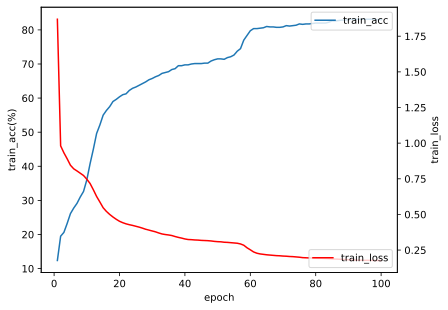

In [152]:
a.show()

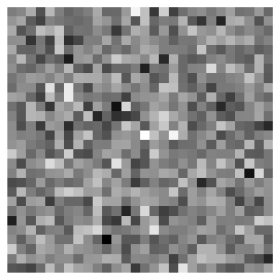

In [121]:
i = 10
show(a.w_hidden[i]+a.bias_hidden[i])

In [ ]:
def show_detail(data,x, y):
    fig, axs = plt.subplots(x,y)
    for i in range(x):
        for j in range(y):
            some_digit = X[i*x+y]
            some_digit_image = some_digit.reshape(28, 28)
            plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
            plt.axis("off")
            plt.show()

In [86]:
X_test

array([], shape=(0, 784), dtype=float64)

In [77]:
print(a.score(X_test,y_test))

7.5
